## Imports and Data

In [1]:
from collections import defaultdict
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import json
import logging
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
from networkx.drawing.nx_agraph import graphviz_layout
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import ward
from scipy.spatial.distance import pdist

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import AgglomerativeClustering

import wiki

logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO
)

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload
%matplotlib inline
from importlib import reload
reload(wiki)
reload(nx)

<module 'networkx' from '/usr/local/lib/python3.6/site-packages/networkx/__init__.py'>

In [3]:
model = LdaModel.load("lda_models/lda_all_corpora_50topics_50passes")
# model.id2word = Dictionary.load("./2194lem.dict")
model.id2word = Dictionary.load("all_corpora.dict")
topic_term = model.state.get_lambda()

2017-09-06 15:59:23,636 : INFO : loading LdaModel object from lda_models/lda_all_corpora_50topics_50passes
2017-09-06 15:59:23,643 : INFO : loading expElogbeta from lda_models/lda_all_corpora_50topics_50passes.expElogbeta.npy with mmap=None
2017-09-06 15:59:23,672 : INFO : setting ignored attribute id2word to None
2017-09-06 15:59:23,673 : INFO : setting ignored attribute state to None
2017-09-06 15:59:23,675 : INFO : setting ignored attribute dispatcher to None
2017-09-06 15:59:23,676 : INFO : loaded lda_models/lda_all_corpora_50topics_50passes
2017-09-06 15:59:23,678 : INFO : loading LdaModel object from lda_models/lda_all_corpora_50topics_50passes.state
2017-09-06 15:59:23,840 : INFO : loaded lda_models/lda_all_corpora_50topics_50passes.state
2017-09-06 15:59:23,881 : INFO : loading Dictionary object from all_corpora.dict
2017-09-06 15:59:23,911 : INFO : loaded all_corpora.dict


In [4]:
model.print_topic(0)

'0.041*"police" + 0.023*"representation" + 0.023*"minority" + 0.018*"bureaucracy" + 0.018*"representative" + 0.017*"race" + 0.014*"diversity" + 0.013*"officer" + 0.012*"racial" + 0.011*"black"'

## Other clustering methods

In [45]:
# MeanShift Clustering
bandwidth = estimate_bandwidth(topic_term, quantile=0.02)
cluster_ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

# Agglomerative
cluster_agg = AgglomerativeClustering(n_clusters=25, linkage='average', affinity='euclidean')

In [46]:
clusters_ms = cluster_ms.fit_predict(topic_term)
clusters_agg = cluster_agg.fit_predict(topic_term)

In [47]:
clusters = clusters_agg

cluster_to_topic_terms = defaultdict(list)
for i, row in enumerate(topic_term):
    cluster_to_topic_terms[clusters[i]].append(model.print_topic(i, topn=4))

for cluster, topics in cluster_to_topic_terms.items():
    print("-" * 60)
    print("Cluster: %d" % cluster)
    for topic in topics:
        print(topic)

------------------------------------------------------------
Cluster: 0
0.093*"participation" + 0.040*"participants" + 0.039*"citizen" + 0.029*"members"
0.015*"african" + 0.008*"children" + 0.008*"educational" + 0.008*"women"
0.085*"yes" + 0.042*"countries" + 0.030*"trade" + 0.022*"investment"
0.148*"maltreatment" + 0.137*"verification" + 0.109*"cms" + 0.086*"abuse"
0.100*"solutions" + 0.097*"universalistic" + 0.060*"bhagwadi" + 0.053*"krauskopf"
0.022*"pile" + 0.015*"stoneâ" + 0.000*"alstott" + 0.000*"trainings"
0.161*"project" + 0.112*"projects" + 0.039*"incentives" + 0.028*"bonus"
0.289*"shale" + 0.043*"geology" + 0.038*"willie" + 0.026*"recess"
0.094*"deregulatory" + 0.057*"sunbelt" + 0.000*"placarded" + 0.000*"alstott"
0.183*"sickness" + 0.109*"individualâ" + 0.019*"contributory" + 0.015*"trujillo"
0.028*"evaluation" + 0.009*"subjects" + 0.008*"experiments" + 0.008*"corps"
0.157*"accountability" + 0.051*"nclb" + 0.036*"reforms" + 0.036*"achievement"
0.060*"sector" + 0.060*"contrac

## Create Dendrogram

In [5]:
distances = pdist(topic_term, metric="cosine")
Z = linkage(distances, 'ward')

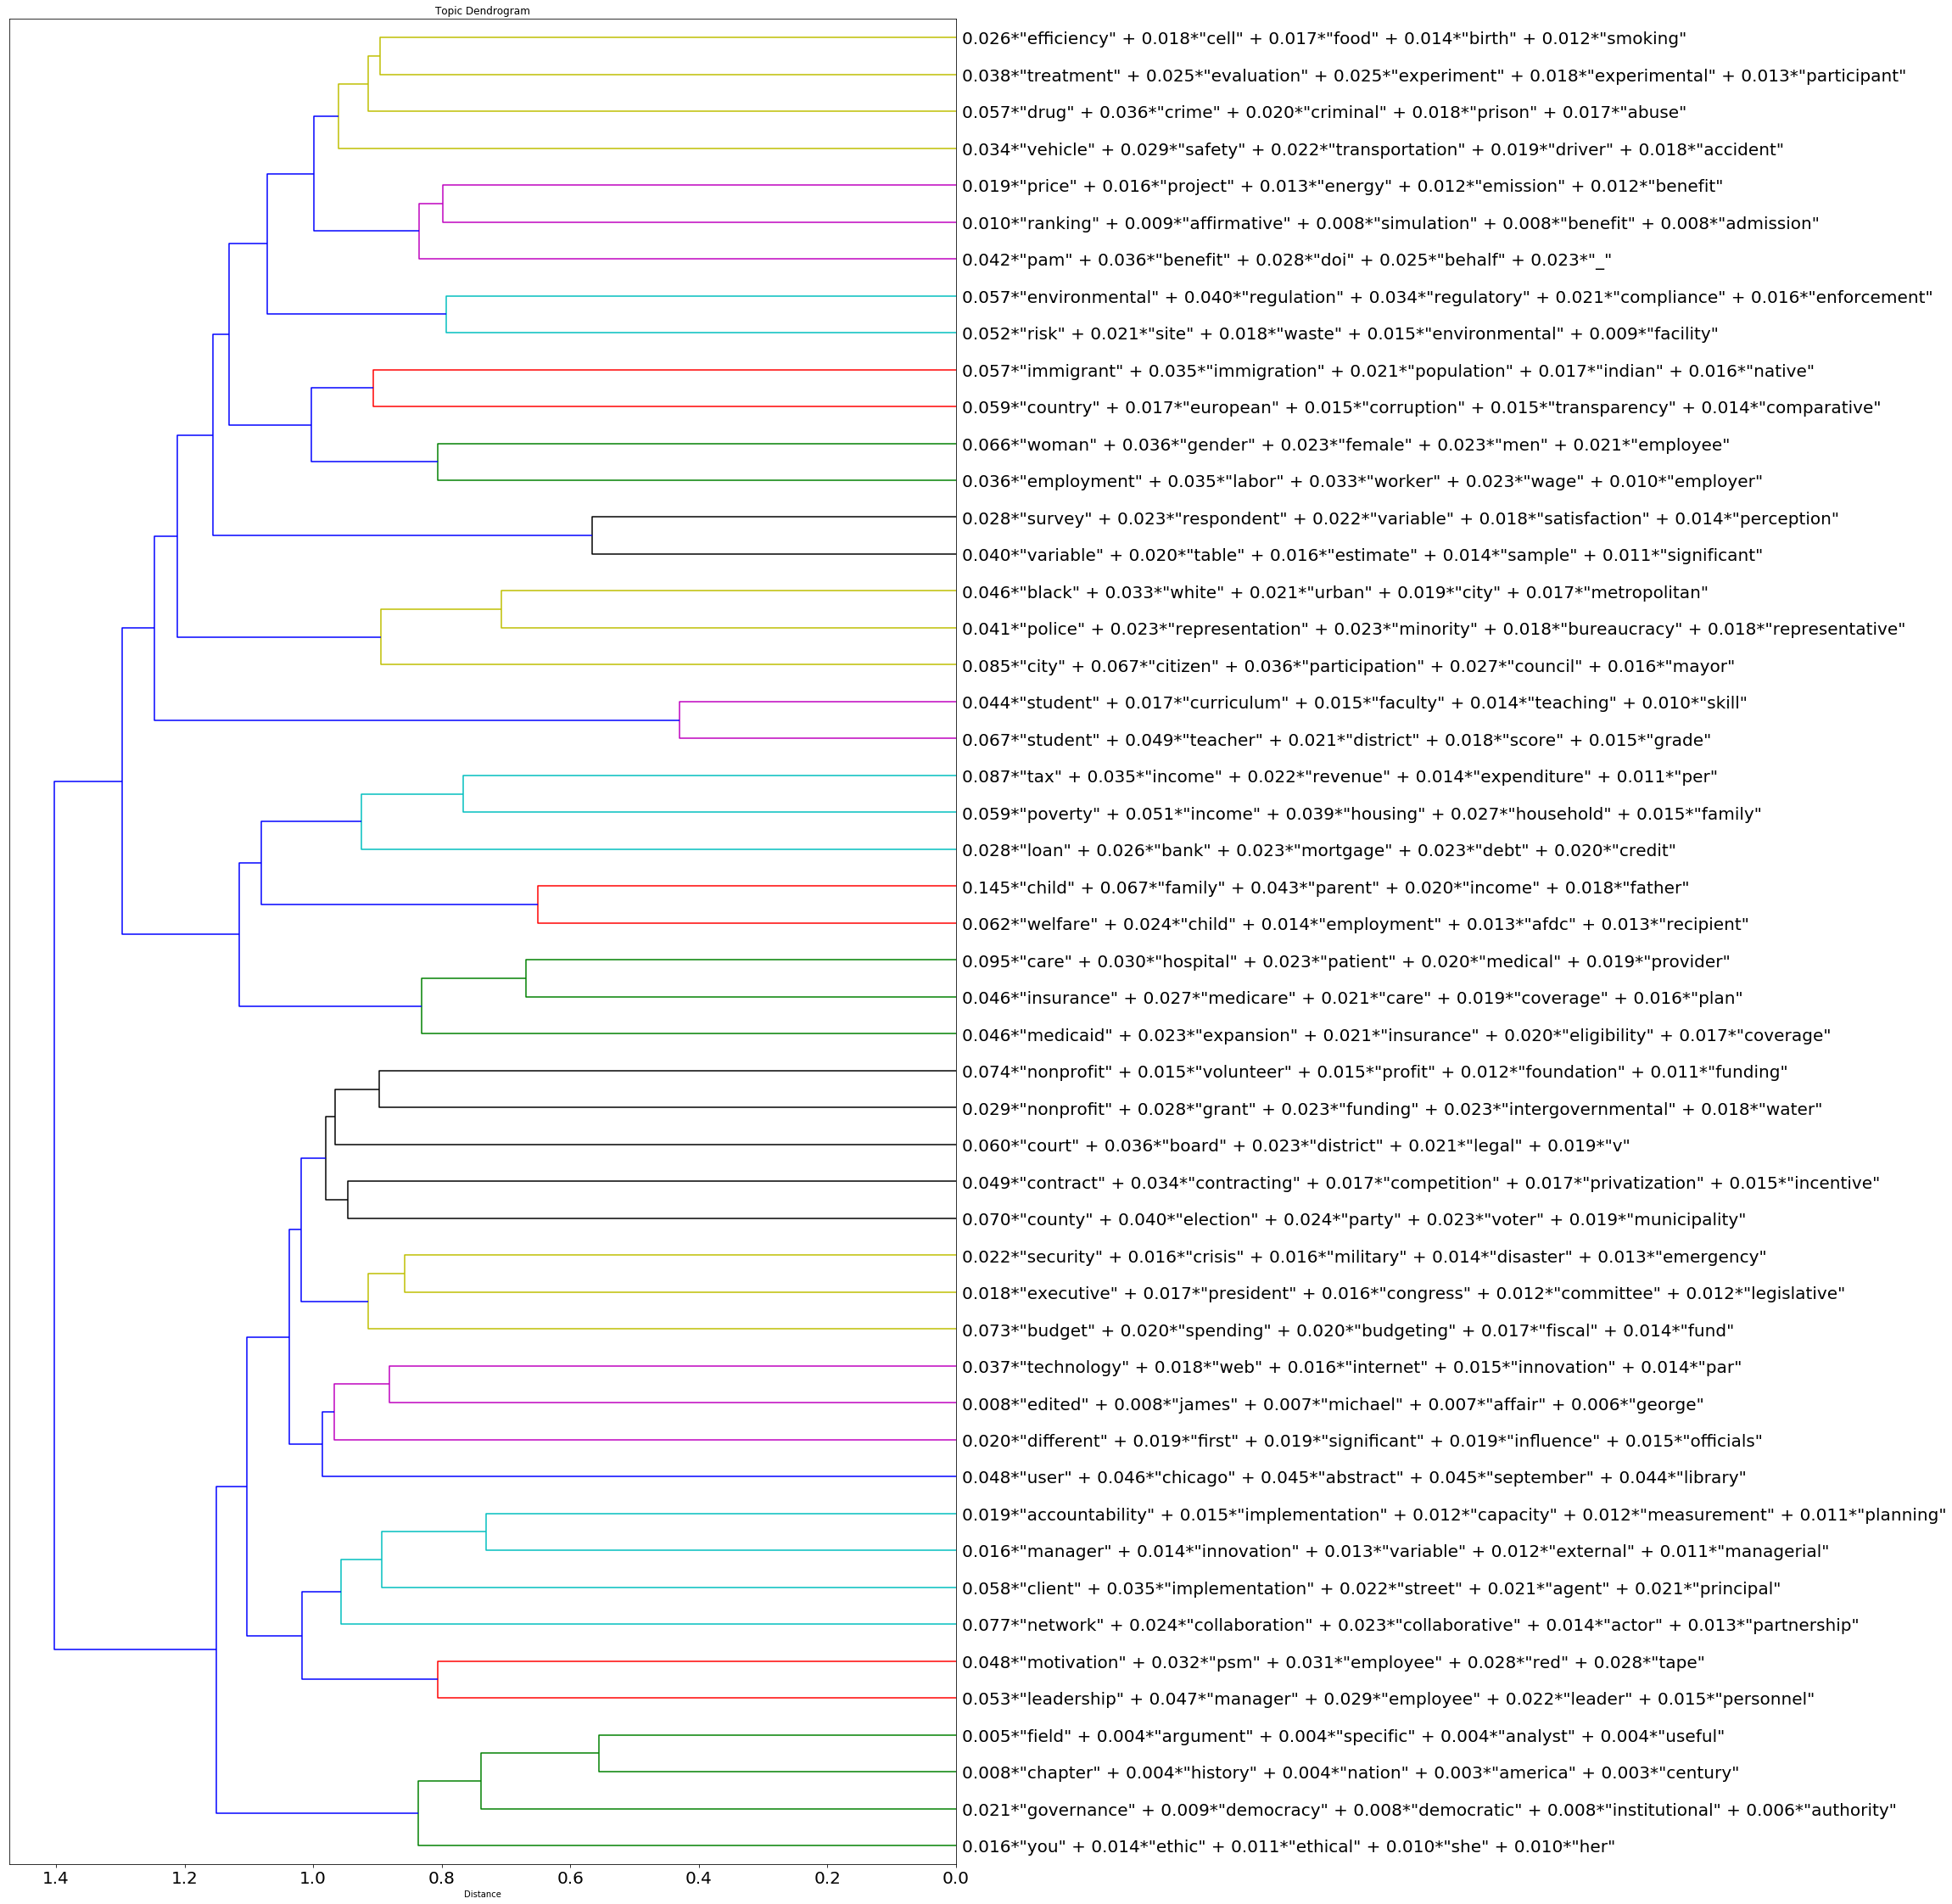

In [6]:
fig = plt.figure(figsize=(20, 40))
plt.title("Topic Dendrogram")
plt.xlabel("Distance")
out = dendrogram(
    Z,
    orientation="left"
)
ax = fig.get_axes()[0]
ylabels = [int(item.get_text()) for item in ax.get_yticklabels()]
ylabels = [model.print_topic(i, topn=5) for i in ylabels]
ylabel_objs = ax.set_yticklabels(ylabels)
ax.tick_params(labelsize=20)
plt.savefig("dendrogram_all_corpora_50.png", dpi=150, bbox_inches='tight')

## Labelling Topics

In [7]:
topic_labels = list()
for topic_num in range(model.num_topics):
    topn = model.show_topic(topic_num, topn=5)
    terms = [term for term, weight in topn]
    labels = wiki.page_labels(terms, n=5)
    topic_labels.append(labels)
stable_topic_labels = topic_labels.copy()

In [8]:
print(model.print_topic(32))
print(topic_labels[32])

0.019*"price" + 0.016*"project" + 0.013*"energy" + 0.012*"emission" + 0.012*"benefit" + 0.012*"investment" + 0.009*"firm" + 0.009*"industry" + 0.008*"climate" + 0.008*"utility"
['Emissions trading', 'Carbon price', 'European Union Emission Trading Scheme', 'Zero-energy building', 'Energy in Norway']


In [16]:
for i, labels in enumerate(topic_labels):
    print(model.print_topic(i))
    print(labels)
    print()

0.039*"ethic" + 0.028*"ethical" + 0.024*"democracy" + 0.022*"democratic" + 0.022*"moral" + 0.013*"professional" + 0.012*"administrator" + 0.010*"citizen" + 0.009*"responsibility" + 0.009*"adr"
['Liberal socialism', 'Nel Noddings', 'Index of social and political philosophy articles', 'Joel H. Rosenthal', 'Social ecology']

0.170*"funding" + 0.160*"fund" + 0.033*"appropriation" + 0.033*"priority" + 0.029*"expenditure" + 0.024*"specie" + 0.017*"million" + 0.017*"funded" + 0.015*"project" + 0.014*"investment"
['Appropriation bill', 'Appropriations bill (United States)', 'Energy and Water Development and Related Agencies Appropriations Act, 2014', 'Expenditures in the United States federal budget', 'Further Continuing and Security Assistance Appropriations Act, 2017']

0.032*"analyst" + 0.010*"technology" + 0.009*"termination" + 0.007*"investment" + 0.007*"statement" + 0.006*"king" + 0.005*"plan" + 0.005*"estimate" + 0.004*"contracting" + 0.004*"solution"
['Real options valuation', 'Cerberu

0.025*"regulatory" + 0.021*"regulation" + 0.018*"comment" + 0.017*"rulemaking" + 0.016*"legislative" + 0.015*"procedure" + 0.010*"participation" + 0.009*"bureaucratic" + 0.008*"policymaking" + 0.008*"coalition"
['Rulemaking', 'Midnight regulations', 'SEC Regulatory Accountability Act', 'United States administrative law', 'Regulatory Flexibility Act']

0.257*"sale" + 0.105*"ban" + 0.080*"trend" + 0.069*"blue" + 0.043*"cal" + 0.041*"sunday" + 0.038*"repeal" + 0.031*"restriction" + 0.025*"day" + 0.019*"medi"
['CalPERS', 'Non-compete clause', 'Adult Use of Marijuana Act', 'TAAG Angola Airlines', 'Asbestos and the law']

0.019*"labor" + 0.018*"unemployment" + 0.017*"recession" + 0.017*"crisis" + 0.016*"employment" + 0.014*"worker" + 0.012*"minimum" + 0.010*"great" + 0.009*"credit" + 0.007*"country"
['Unemployment', 'Unemployment in the United States', 'Unemployment benefits', '1973–75 recession', 'Recession']

0.072*"technology" + 0.043*"adoption" + 0.024*"innovation" + 0.015*"speciﬁc" + 0.

0.135*"country" + 0.068*"international" + 0.063*"global" + 0.041*"trade" + 0.037*"china" + 0.023*"japan" + 0.015*"soviet" + 0.014*"republic" + 0.014*"nation" + 0.011*"kyoto"
['International trade', 'Global waste trade', 'Globalization in China', 'China Council for the Promotion of International Trade', 'China International Fair for Investment and Trade']

0.044*"efficiency" + 0.035*"competition" + 0.023*"price" + 0.019*"water" + 0.014*"firm" + 0.013*"commercial" + 0.012*"output" + 0.012*"production" + 0.012*"input" + 0.011*"product"
['Price discrimination', 'Competition', 'European Union competition law', 'Water privatization', 'Microeconomics']

0.098*"employee" + 0.047*"personnel" + 0.036*"pay" + 0.029*"turnover" + 0.027*"leave" + 0.019*"career" + 0.015*"merit" + 0.014*"civil" + 0.012*"tenure" + 0.012*"position"
['Turnover (employment)', 'Leave of absence', 'Sick leave', 'Employee benefits', 'Employee offboarding']

0.065*"_" + 0.031*"pm" + 0.031*"page" + 0.028*"pam" + 0.028*"qxd" + 

0.032*"respondent" + 0.011*"score" + 0.011*"assessment" + 0.011*"sample" + 0.009*"perception" + 0.009*"scale" + 0.008*"attitude" + 0.008*"asked" + 0.008*"perceived" + 0.008*"item"
['Survey methodology', 'Psychopathic Personality Inventory', 'SERVQUAL', 'Projective test', 'Rorschach test']

0.013*"project" + 0.008*"company" + 0.008*"technology" + 0.007*"operation" + 0.007*"military" + 0.007*"reliability" + 0.007*"nasa" + 0.005*"force" + 0.005*"subscription" + 0.005*"complex"
['Operation Paperclip', 'List of military operations', 'Project Azorian', 'Operation CHAOS', 'Covert operation']

0.054*"innovation" + 0.016*"npm" + 0.013*"target" + 0.012*"zealand" + 0.012*"entrepreneur" + 0.011*"canada" + 0.010*"innovative" + 0.010*"civil" + 0.010*"canadian" + 0.010*"idea"
['New public management']

0.038*"executive" + 0.023*"appointee" + 0.021*"president" + 0.016*"appointment" + 0.011*"military" + 0.010*"presidential" + 0.010*"defense" + 0.010*"career" + 0.008*"war" + 0.008*"security"
['President

In [9]:
topic_labels = stable_topic_labels.copy()

In [10]:
G = nx.DiGraph()
print("Adding %d nodes" % len(topic_labels))
for topic_num, labels in enumerate(topic_labels):
    G.add_node(topic_num, labels=labels)

Adding 50 nodes


/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


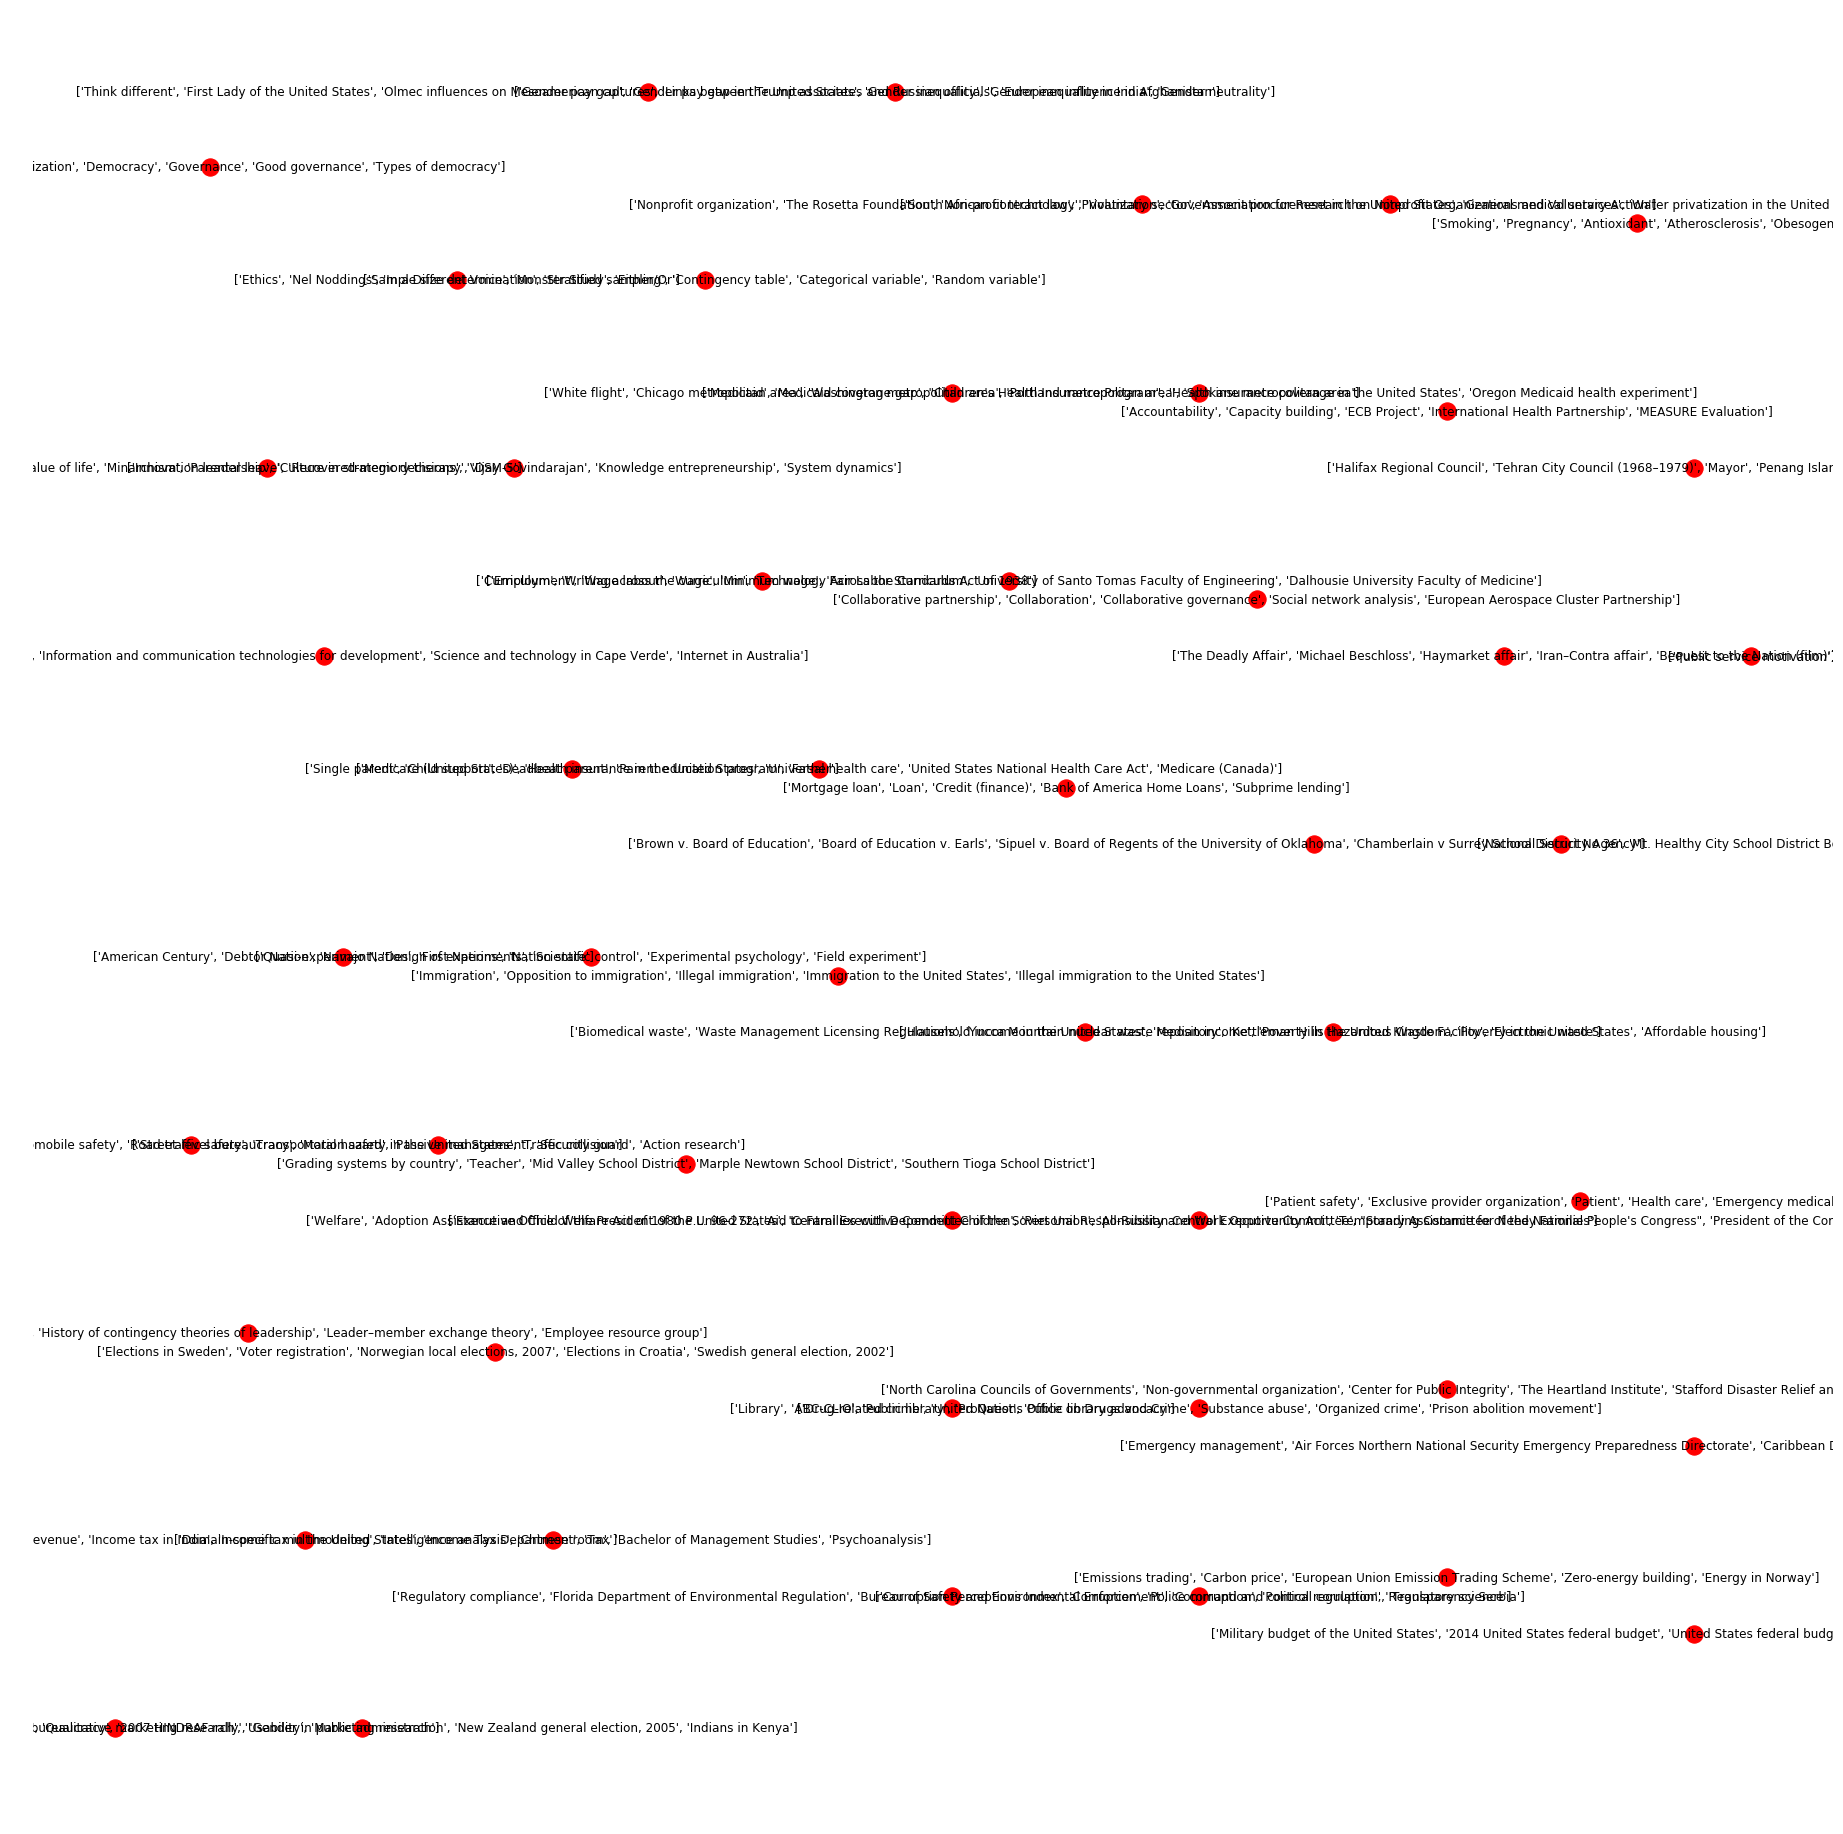

In [11]:
plt.figure(figsize=(25, 25))
pos = graphviz_layout(G)
gdraw = nx.draw(G, pos)
labeldraw = nx.draw_networkx_labels(G, pos, dict(enumerate(topic_labels)))

In [12]:
%autoreload
for id1, id2, dist, sample_cnt in Z:
    new_id = G.number_of_nodes()
    labels1 = list(G.node[id1]["labels"])
    labels2 = list(G.node[id2]["labels"])
    print(id1, id2, "->", new_id)
    print(labels1, labels2)
    new_labels = wiki.list_sca(labels1, labels2, depth=10, pl=1000)
    # new_labels = wiki.central(labels1 + labels2, max_depth=3)
    # new_labels = wiki.highcatrank(labels1 + labels2, max_depth=3)
    # new_labels = wiki.highpagerank(labels1 + labels2, max_depth=1)
    print(new_labels)
    topic_labels.append(new_labels)
    G.add_node(new_id, labels=new_labels)
    G.add_edge(id1, new_id)
    G.add_edge(id2, new_id)
    print("-" * 60)
        

4.0 8.0 -> 50
['Grading systems by country', 'Teacher', 'Mid Valley School District', 'Marple Newtown School District', 'Southern Tioga School District'] ['Curriculum', 'Writing across the curriculum', 'Technology Across the Curriculum', 'University of Santo Tomas Faculty of Engineering', 'Dalhousie University Faculty of Medicine']
Limiter 10; Front1: 5; Front2: 5
Limiter 9; Front1: 16; Front2: 12
Limiter 8; Front1: 40; Front2: 36
{'Category:Education'} 4
{'Category:Education'} 4
Limiter 2; Front1: 112; Front2: 112
{'Category:Education', 'Category:Teaching'} 4
{'Category:Education', 'Category:Teaching'} 4
{'Category:Education', 'Category:Teaching'} 4
{'Category:Education', 'Category:Teaching'} 4
{'Category:Education', 'Category:Teaching'} 4
Limiter 1; Front1: 318; Front2: 331
{'Category:Education', 'Category:Teaching'} 4
{'Category:Education', 'Category:Teaching'} 4
{'Category:Education', 'Category:Teaching'} 4
{'Category:Education', 'Category:Teaching'} 4
{'Category:Education', 'Categ

Limiter 9; Front1: 9; Front2: 24
Limiter 8; Front1: 28; Front2: 96
Limiter 7; Front1: 102; Front2: 295
{'Category:Social issues'} 6
{'Category:Technology by type', 'Category:Social issues'} 6
{'Category:Technology by type', 'Category:Social issues'}
------------------------------------------------------------
39.0 45.0 -> 61
['Leadership', 'Leadership development', 'History of contingency theories of leadership', 'Leader–member exchange theory', 'Employee resource group'] ['Public service motivation']
Limiter 10; Front1: 5; Front2: 1
Limiter 9; Front1: 12; Front2: 3
{'Category:Human resource management'} 2
Limiter 1; Front1: 39; Front2: 12
{'Category:Human resource management'}
------------------------------------------------------------
9.0 46.0 -> 62
['Employment', 'Wage labour', 'Wage', 'Minimum wage', 'Fair Labor Standards Act of 1938'] ['Gender pay gap', 'Gender pay gap in the United States', 'Gender inequality', 'Gender inequality in India', 'Gender neutrality']
Limiter 10; Front

Limiter 9; Front1: 24; Front2: 15
Limiter 8; Front1: 88; Front2: 50
{'Category:Crimes'} 3
{'Category:Criminal law', 'Category:Crimes'} 3
{'Category:Criminal law', 'Category:Morality', 'Category:Crimes'} 3
{'Category:Criminal law', 'Category:Morality', 'Category:Crime', 'Category:Crimes'} 3
{'Category:Criminal law', 'Category:Morality', 'Category:Crime', 'Category:Crimes'} 3
{'Category:Criminal law', 'Category:Morality', 'Category:Crime', 'Category:Crimes'} 3
{'Category:Crime', 'Category:Crimes', 'Category:Concepts in ethics', 'Category:Morality', 'Category:Criminal law'} 3
Limiter 1; Front1: 275; Front2: 154
{'Category:Crime', 'Category:Crimes', 'Category:Concepts in ethics', 'Category:Morality', 'Category:Criminal law'} 3
{'Category:Crime', 'Category:Crimes', 'Category:Concepts in ethics', 'Category:Morality', 'Category:Criminal law'} 3
{'Category:Crime', 'Category:Crimes', 'Category:Concepts in ethics', 'Category:Morality', 'Category:Criminal law'} 3
{'Category:Crime', 'Category:Crim

{'Category:Subfields by academic discipline', 'Category:Categories by topic'} 6
{'Category:Subfields by academic discipline', 'Category:Categories by topic'} 6
{'Category:Subfields by academic discipline', 'Category:Categories by topic'} 6
{'Category:Subfields by academic discipline', 'Category:Categories by topic'} 6
{'Category:Subfields by academic discipline', 'Category:Categories by topic'} 6
{'Category:Subfields by academic discipline', 'Category:Categories by topic'} 6
{'Category:Subfields by academic discipline', 'Category:Categories by topic'} 6
{'Category:Subfields by academic discipline', 'Category:Categories by topic'} 6
{'Category:Subfields by academic discipline', 'Category:Categories by topic'} 6
{'Category:Subfields by academic discipline', 'Category:Categories by topic'} 6
{'Category:Subfields by academic discipline', 'Category:Categories by topic'} 6
{'Category:Subfields by academic discipline', 'Category:Categories by topic'} 6
{'Category:Subfields by academic discipl

In [13]:
print(len(topic_labels))
list_topic_labels = [list(labels) for labels in topic_labels]
json.dump(
    {"labels":list_topic_labels, "linkage": Z.tolist()}, 
    open("lda_all_corpora_50topics_50pass_cluster_labels.json", "w")
)

99


In [21]:
 topic_labels = dict(enumerate(topic_labels))

In [22]:
%autoreload
# limited_topic_labels = {ix: list(topics)[:2] for ix, topics in topic_labels.items()}
limited_topic_labels = topic_labels.copy()
filtered_topic_labels = {
    ix: [label for label in labels if not wiki.BAD(label)]
    for ix, labels in limited_topic_labels.items()
}

## Pruning the tree

In [24]:
pG = G.copy()
pruned_topic_labels = filtered_topic_labels.copy()
for node, labels in pruned_topic_labels.items():
    pG.add_node(node, labels=labels)

### Remove unlabeled nodes

In [25]:
unlabeled_nodes = [
    node for node in pG
    if len(pG.node[node]["labels"]) == 0
]

print("Found %d unlabeled nodes" % len(unlabeled_nodes))

for node in unlabeled_nodes:
    parents = pG.successors(node)
    if len(parents) != 1:
        continue
    parent = parents[0]
    for child in pG.predecessors(node):
        pG.add_edge(child, parent)
        pG.remove_edge(int(child), node)
    pG.remove_edge(node, parent)
    pG.remove_node(node)
    del pruned_topic_labels[node]
    
for node in pG.nodes():
    if node not in pruned_topic_labels:
        pG.remove_node(node)

Found 51 unlabeled nodes


### Collapse chains

In [26]:
chain_children = [
    n
    for n in pG.nodes() 
    if pG.out_degree(n) and 
    pG.node[pG.successors(n)[0]]["labels"] == pG.node[n]["labels"]
]

print("Found %d child-parent pairs with the same label" % len(chain_children))

for node in chain_children:
    parent = pG.successors(node)[0]
    for child in pG.predecessors(node):
        pG.add_edge(child, parent)
    pG.remove_node(node)
    del pruned_topic_labels[node]

Found 13 child-parent pairs with the same label


In [27]:
dd = defaultdict(list)
dd.update({node: labels[:2] for node, labels in pruned_topic_labels.items()})

/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


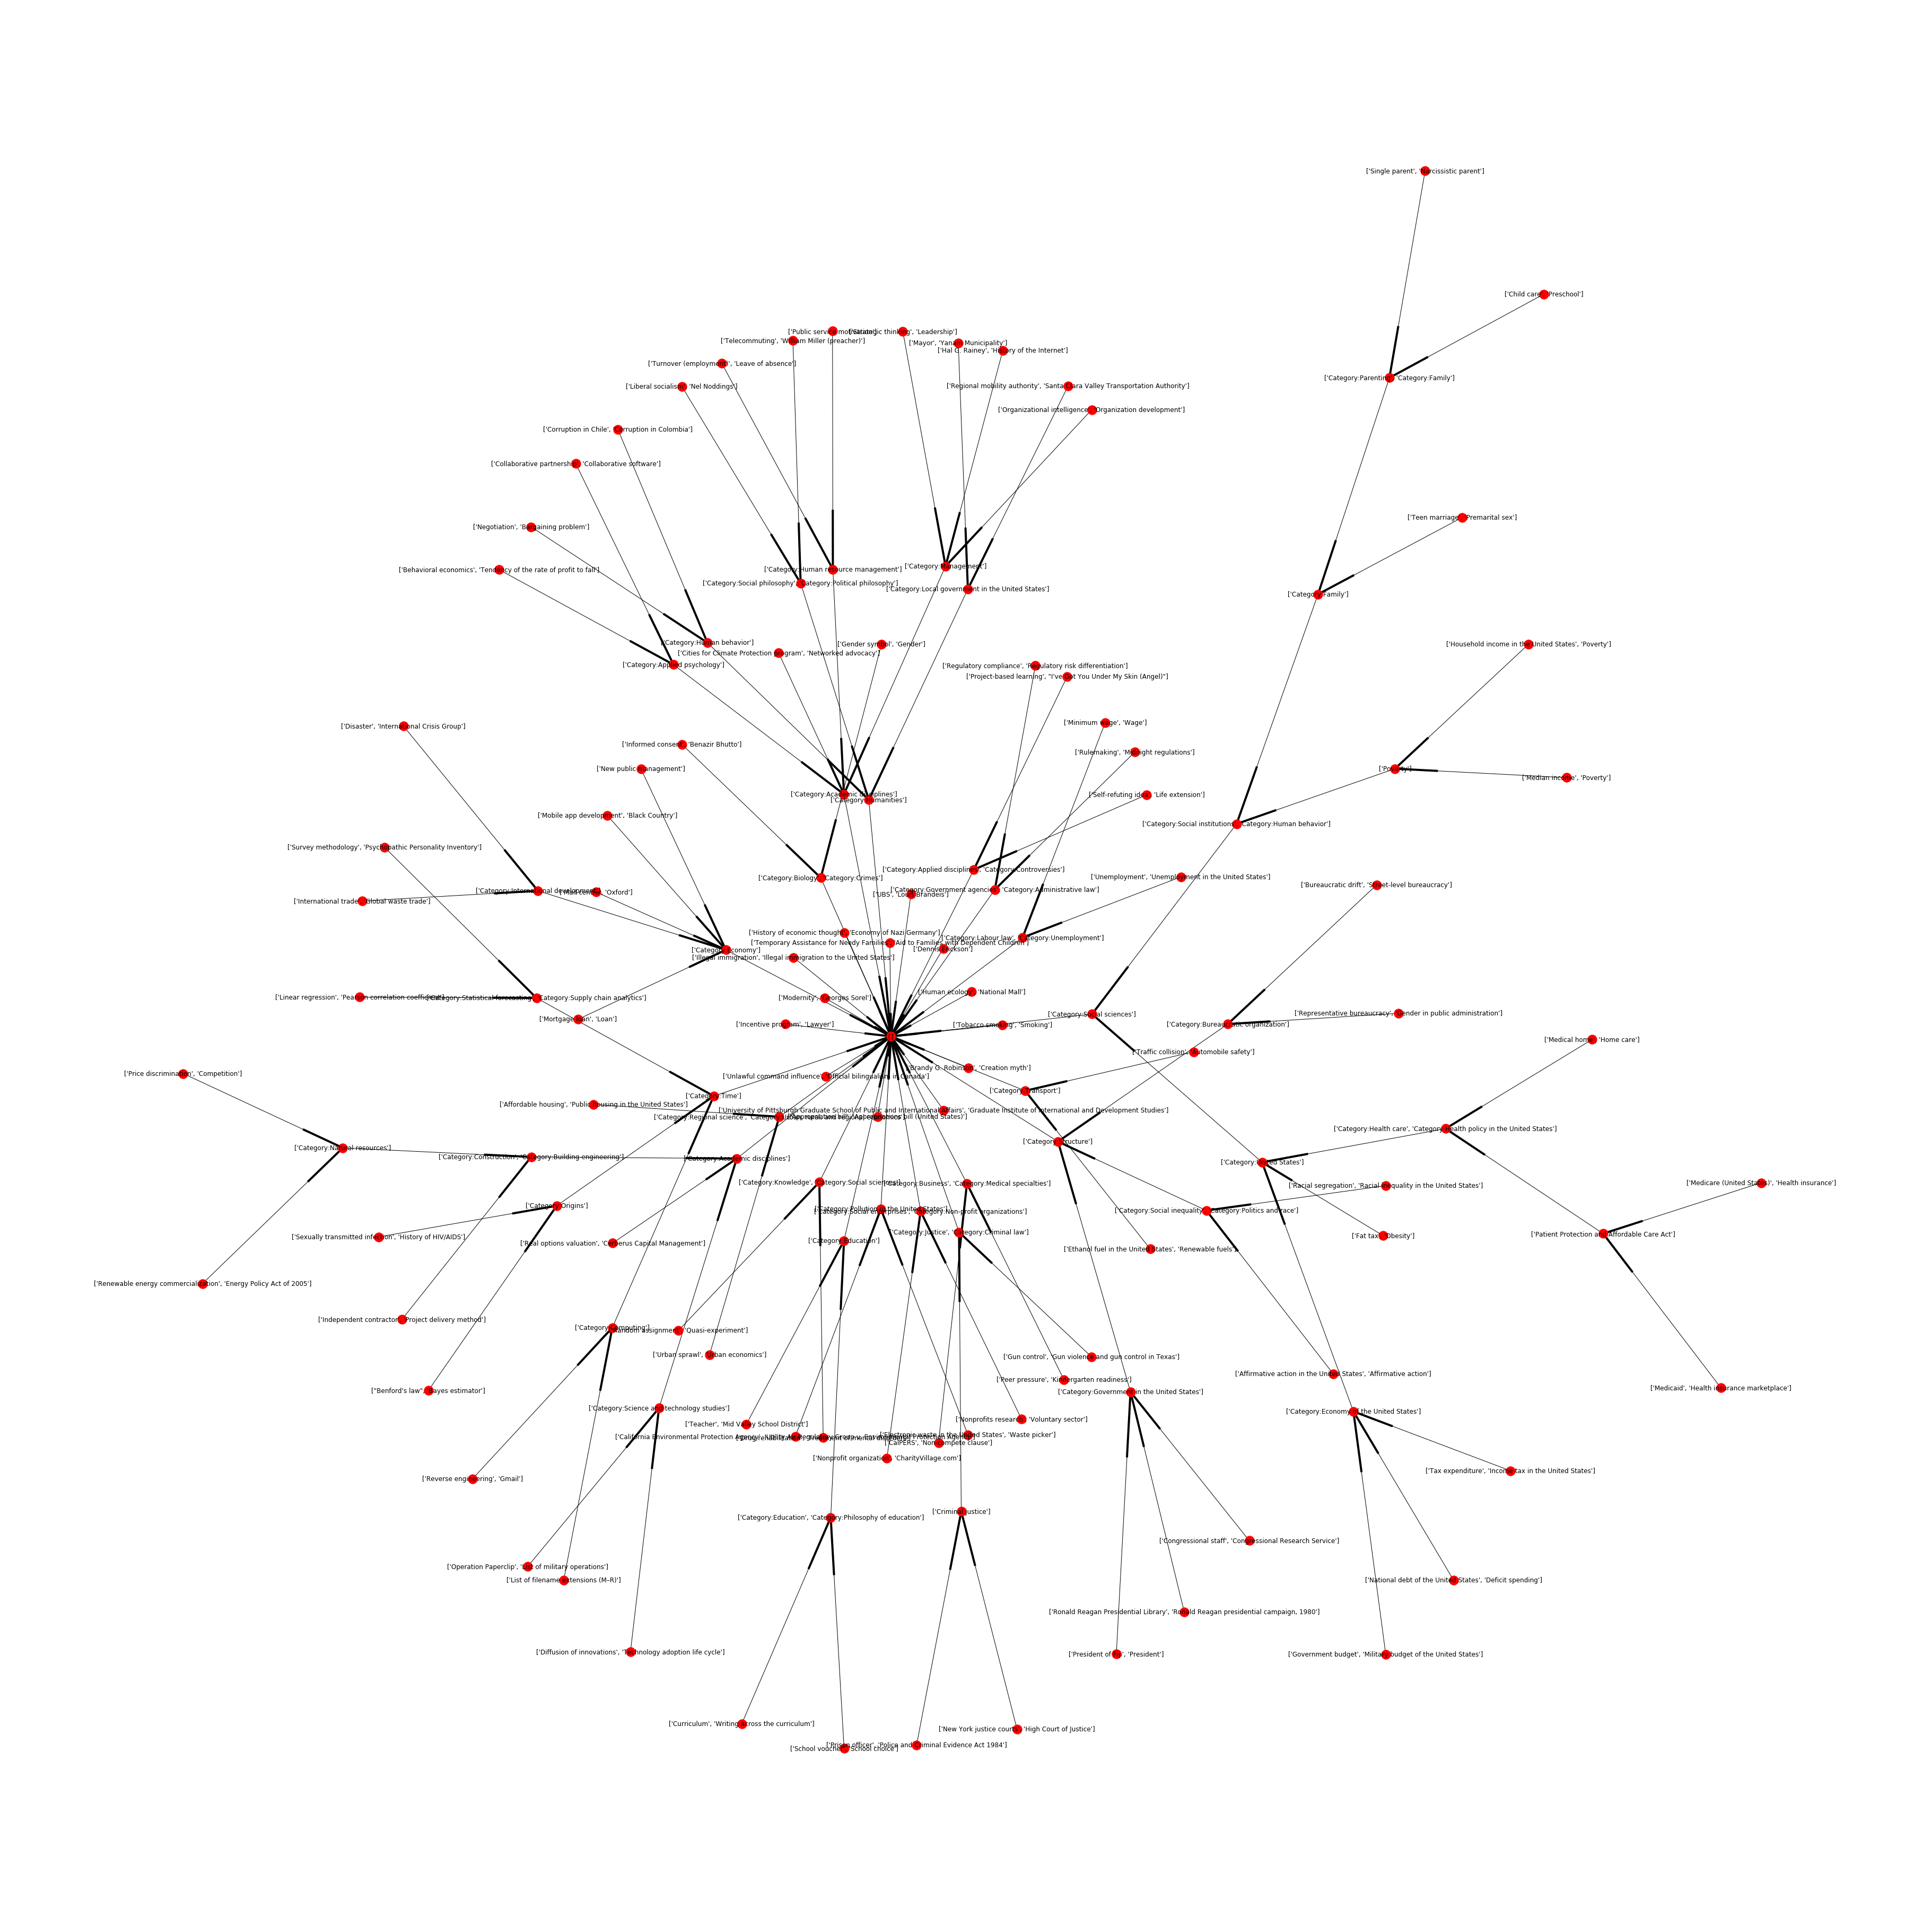

In [28]:
plt.figure(figsize=(50, 50))
pos = graphviz_layout(pG)
nx.draw(pG, pos)
nx.draw_networkx_labels(pG, pos, dd)
plt.savefig("tree_pruned_sca_all.png", dpi=150)
plt.show()

In [29]:
roots = [node for node in pG.nodes() if pG.out_degree(node) == 0]
root = roots[0]
writer = open("ascii_pruned_sca_all.txt", "w")

def _dfs_write(G, node, depth, wr):
    indent = "\t" * depth
    wr.write(indent + "%d %s\n" % (node, list(pruned_topic_labels[node])[:3]))
    if node < model.num_topics:
        wr.write(indent + model.print_topic(int(node), topn=5))
        wr.write("\n")
    wr.write("\n")
    for child in G.predecessors(node):
        _dfs_write(G, child, depth + 1, wr)

_dfs_write(pG, root, 0, writer)
writer.close()

In [30]:
import pickle
pickle.dump(pG, open("pruned_all_graph.pl", "wb"))

## Drawing Graph

/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


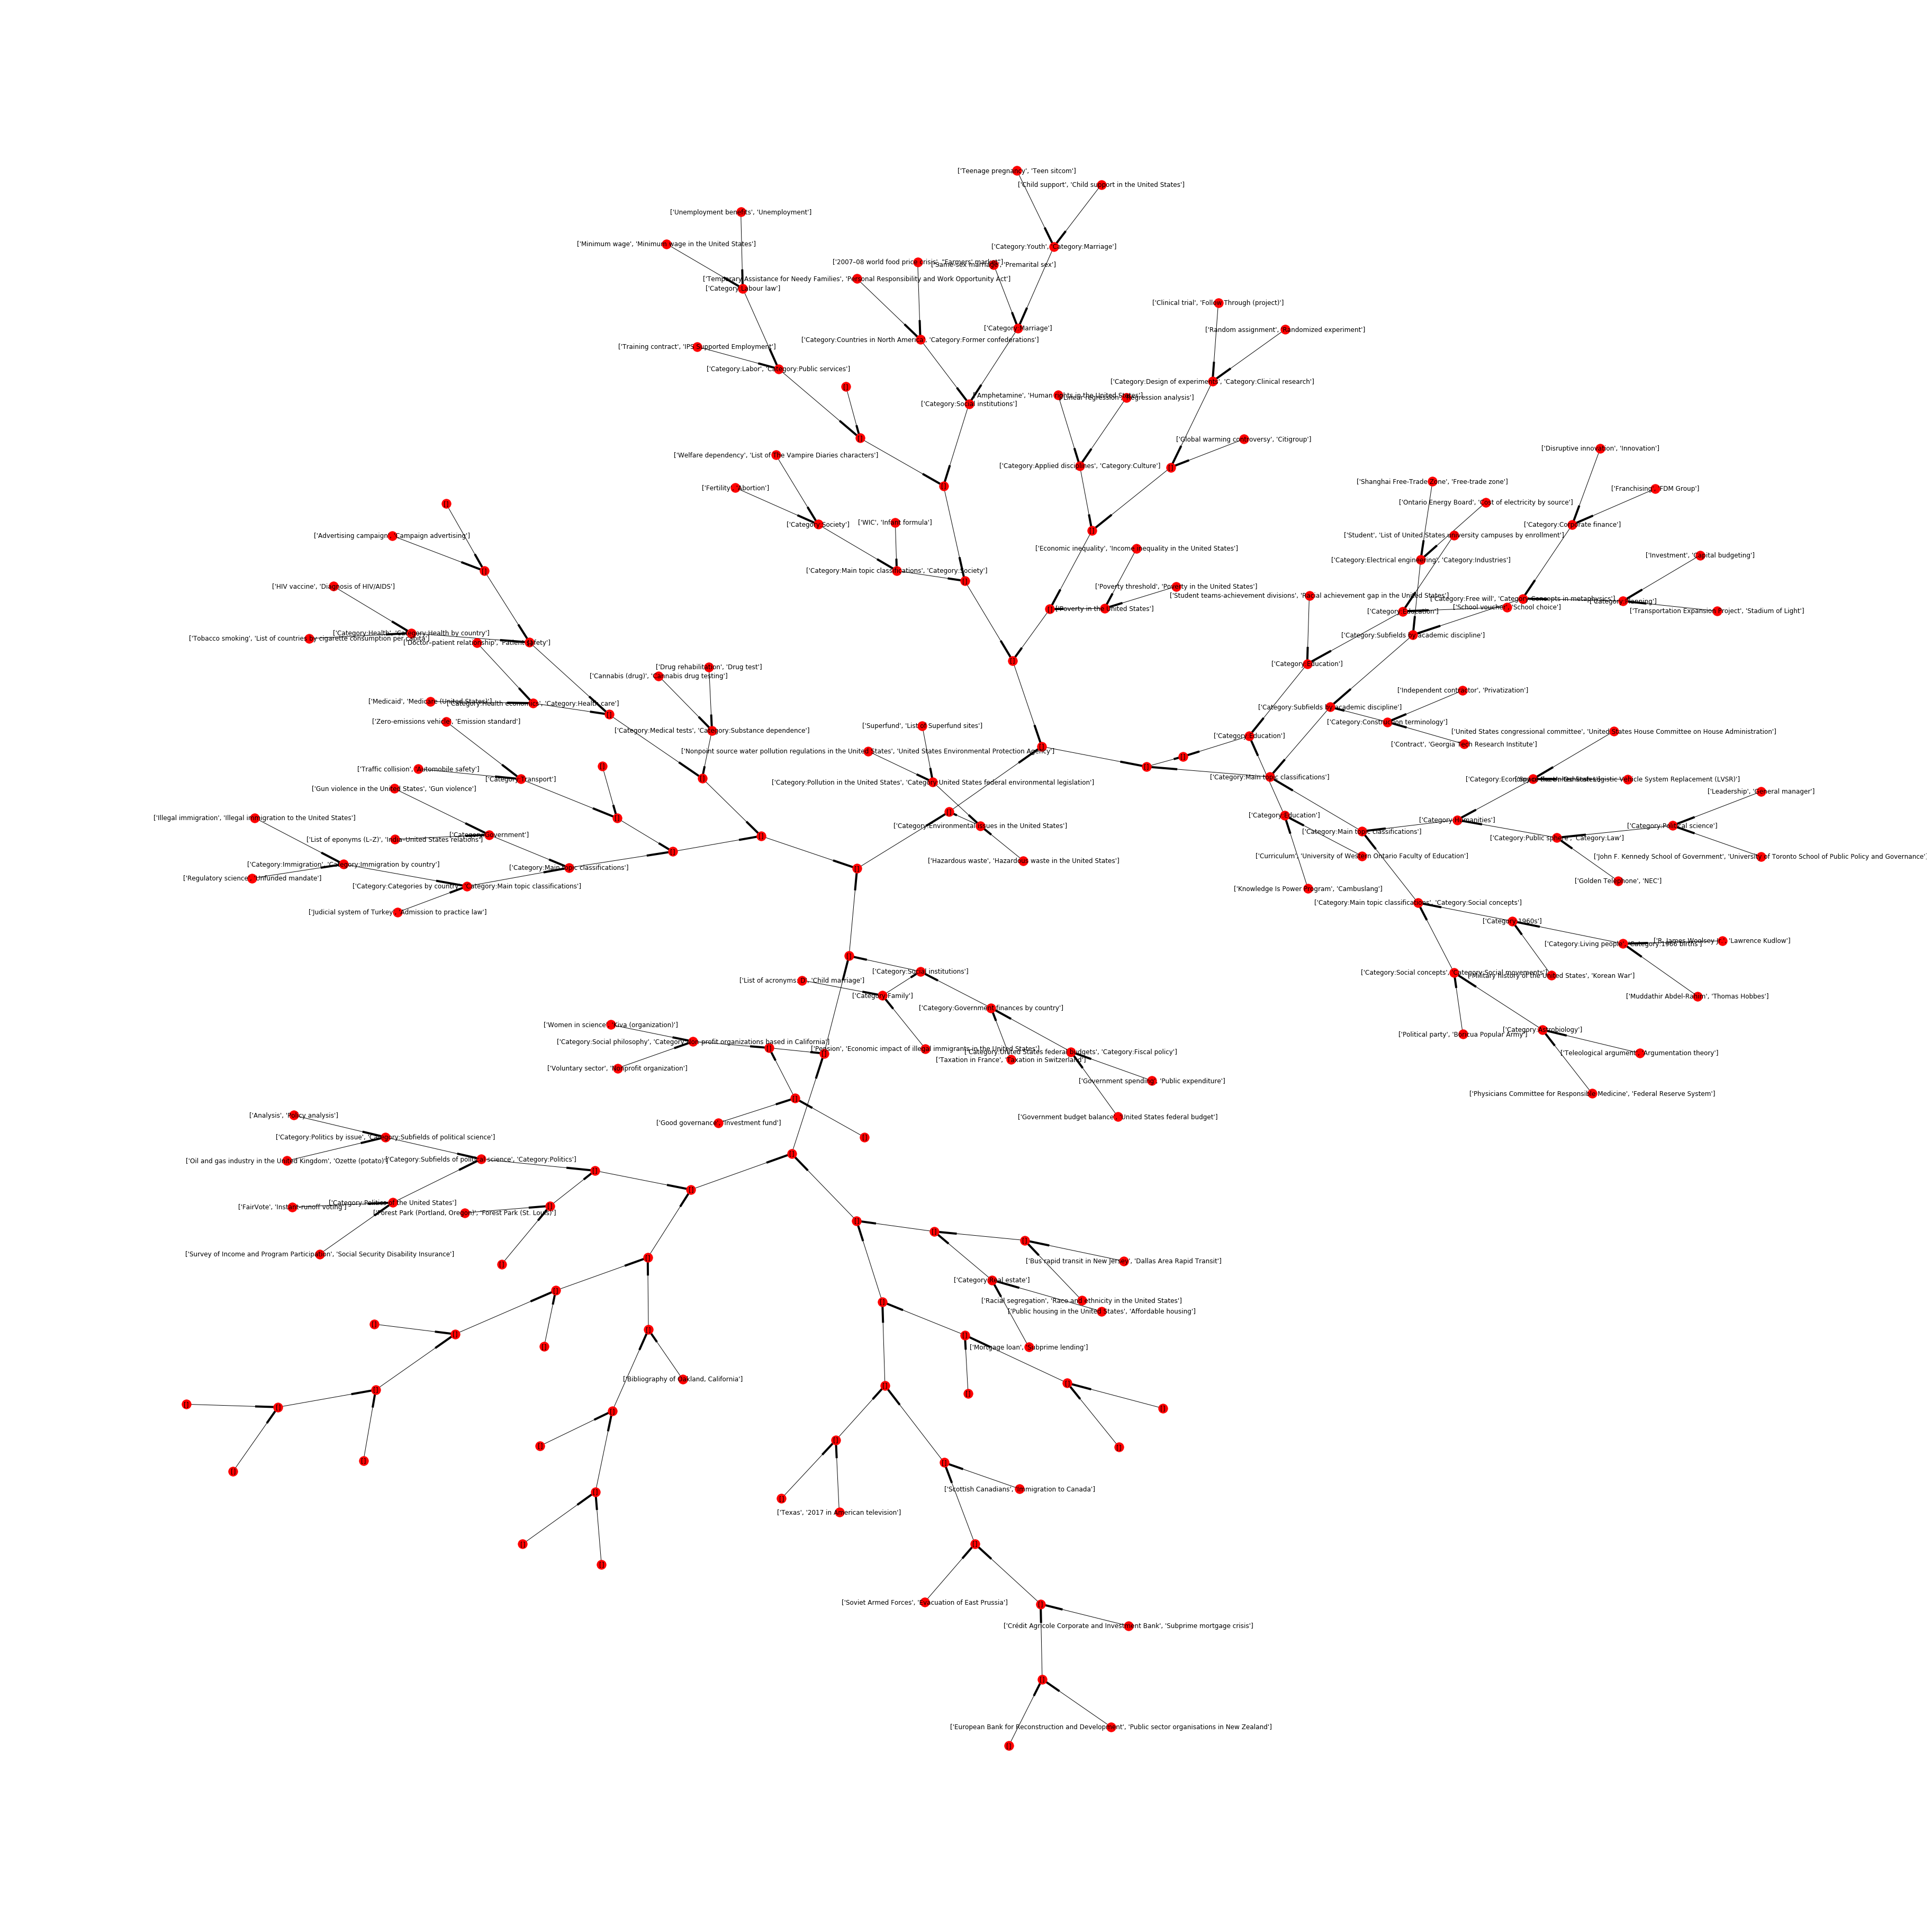

In [98]:
plt.figure(figsize=(50, 50))
pos = graphviz_layout(G)
nx.draw(G, pos)
nx.draw_networkx_labels(G, pos, limited_topic_labels)
plt.savefig("tree_gv_sca_lem.png", dpi=150)
plt.show()

In [54]:
topics

In [65]:
print(topic_labels[23], ":", model.print_topic(23))
print()
print()
print(topic_labels[81], ":", model.print_topic(81))

['Political economy', 'Free trade'] : 0.026*"book" + 0.011*"reviews" + 0.007*"chapter" + 0.004*"trade" + 0.004*"economy" + 0.003*"military" + 0.003*"institutions" + 0.003*"argues" + 0.003*"books" + 0.003*"soviet"


['Political economy', 'Networks and States'] : 0.017*"book" + 0.007*"reviews" + 0.005*"chapter" + 0.004*"politics" + 0.003*"institutions" + 0.003*"implementation" + 0.003*"ideas" + 0.003*"field" + 0.003*"action" + 0.003*"managers"


In [67]:
wiki.merge(topic_labels[23], topic_labels[81])

{'Category:Economic systems',
 'Category:Political economy',
 'Category:Schools of economic thought'}

In [142]:
topic_labels

{0: ['Naval artillery', 'David M. Kennedy (criminologist)'],
 1: ['Freedom of contract', 'Social contract'],
 2: ['Stem cell', 'Embryonic stem cell'],
 3: ['Special education', 'Bunce Court School'],
 4: ['Medicaid', 'Medicare (United States)'],
 5: ['Regulatory compliance',
  'Florida Department of Environmental Regulation'],
 6: ['University of Pittsburgh Graduate School of Public and International Affairs',
  'Association of Professional Schools of International Affairs'],
 7: ['Rule of law',
  'American Bar Association Model Rules of Professional Conduct'],
 8: ['Head Start (program)', 'Child abuse'],
 9: ['HTTP cookie', 'Hypertext Transfer Protocol'],
 10: ['Diagnosis of HIV/AIDS', 'HIV/AIDS in China'],
 11: ['Robert the Bruce', 'Modernity'],
 12: ['Ethics', 'Deontological ethics'],
 13: ['Racial inequality in the United States', 'Racial segregation'],
 14: [],
 15: ['Random variable', 'Categorical variable'],
 16: ['Automobile safety', 'National Highway Traffic Safety Administrat

In [74]:
print(model.print_topic(30))
print()
print(model.print_topic(59))

0.019*"variables" + 0.017*"table" + 0.016*"estimates" + 0.015*"variable" + 0.015*"sample" + 0.009*"treatment" + 0.008*"estimate" + 0.007*"x" + 0.007*"estimated" + 0.007*"mean"

0.016*"yes" + 0.012*"table" + 0.010*"variable" + 0.010*"vehicle" + 0.009*"gasoline" + 0.009*"laws" + 0.008*"º" + 0.008*"safety" + 0.007*"variables" + 0.007*"estimates"
